In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.metrics import mean_squared_error

In [2]:
from torch import nn
import torch
from torch.nn  import functional as F
import torch.optim as  optim 
if torch.cuda.is_available():  
  dev = "cuda:0" 
  print("gpu up")
else:  
  dev = "cpu"  
device = torch.device(dev)
device

device(type='cpu')

#### In this section I am getting the dataset from the local folders. There are three different data I am retrieving. 

users conatains the sub-user's data. 

anime contains the details data of different animes available. 

main_creators contains the  creators data for all the animes. 


In [3]:
users = pd.read_csv("data/users.csv").drop("Unnamed: 0",axis=1)
anime = pd.read_csv("data/anime.csv").drop("Unnamed: 0",axis=1)
main_creators = pd.read_csv("data/main_creators.csv").drop("Unnamed: 0",axis=1)

In [4]:
users.nunique()

user_group    7551
anime_id      1664
sub_year        12
dtype: int64

In [5]:
anime.nunique()

anime_id      1275
name          1275
type             1
rating         366
genre          852
episodes        87
creators        29
aired_year      16
awards_no        9
descript      1225
dtype: int64

#### In this section I am filling all the anime rows with Null vlaues in which has blank or no data 

In [6]:
"""
we will replace null values from categorical columns with "NULL"(like it's a new category) 
and for the rating column we will use the mean
"""
anime.genre.fillna("NULL",inplace=True)
anime.type.fillna("NULL",inplace=True)
anime.rating.fillna(anime.rating.mean(),inplace=True)

#### In this section, I am just dropping all the animes which were subbed by the user group but were not preset in the anime dataset. 

In [7]:
bad_animes = [x  for x in users.anime_id.unique() if x not in anime.anime_id.unique() ] 
anime_indecies = users[users.anime_id.isin(bad_animes)].index
users.drop(anime_indecies,inplace=True)


#### In this section, I have merged the anime dataset with the main_creator dataset to create a anime creators matrix and renaming the dataset as base.

In [8]:
anime_with_creators= pd.merge(anime,main_creators,how="left",on="anime_id")
#creatorsMean = anime_with_creators.creators.mean()
base = anime_with_creators.copy() 

In [9]:
base.drop(["episodes","name","descript","rating"],axis=1,inplace=True) #dropped episodes  many null values 
#base.head(5)

#### In this section, I have created a function which splits the genres from the genre column and create a matrix same as the creators.

In [10]:
base.genre = base.genre.apply(lambda x: " ".join(x.split(" ")).split(", ")) #to remove unnecessary spaces

In [11]:
genres = [] # generating the genres data
for i in range(len(base)):
    for g in base.genre[i]:
        if g in genres:
            base["genre_"+g][i] = 1
        else:
            base["genre_"+g] = 0
            base["genre_"+g][i] = 1
            genres.append(g)


<ipython-input-11-d4b672a8d521>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["genre_"+g][i] = 1
<ipython-input-11-d4b672a8d521>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["genre_"+g][i] = 1


In [12]:
base = pd.concat([base,pd.get_dummies(base['type'], prefix='type',dummy_na=True)],axis=1).drop(['type'],axis=1)

In [13]:
base.head(5)

,anime_id,genre,creators,aired_year,awards_no,creator_1,creator_2,creator_3,creator_4,creator_5,...,genre_Martial Arts,genre_Thriller,genre_Demons,genre_Samurai,genre_Parody,genre_Shounen Ai,genre_Josei,genre_Shoujo Ai,type_TV Series,type_nan
0,1,"[Action, Military, Romance, Sci-Fi, Space]",15,1999,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,4,"[Action, Military, Romance, Sci-Fi, Space]",15,2000,2,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,5,"[Action, Military, Romance, Sci-Fi, Space]",15,2001,4,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,8,"[Action, Adventure, Fantasy, Music, Romance, S...",17,2002,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,12,"[Comedy, Drama, Ecchi, Romance, Sci-Fi, Seinen]",15,2002,1,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


#### In this section, I have merged the users dataset with the base dataset which has all the information of a anime

In [14]:
users =users[["sub_year","user_group","anime_id"]] # rearranging columns
base= pd.merge(users,base,how="left",on="anime_id")

In [15]:
#base.creators.fillna(creatorsMean,inplace=True)
base.drop(["genre"],axis=1,inplace=True)

In [16]:
base.fillna(0,inplace=True) # for any 

In [17]:
base.head(5)

,sub_year,user_group,anime_id,creators,aired_year,awards_no,creator_1,creator_2,creator_3,creator_4,...,genre_Martial Arts,genre_Thriller,genre_Demons,genre_Samurai,genre_Parody,genre_Shounen Ai,genre_Josei,genre_Shoujo Ai,type_TV Series,type_nan
0,2002,1,1,15,1999,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,2002,1,12,15,2002,1,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,2002,1,26,17,2002,2,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,2002,1,86,15,2002,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,2002,1,146,18,2002,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


#### Here I am splitiing the dataset for training set and test set.

In [18]:
import random
random.seed(42)

"""
we will use 10000 rows for validation data and rest of them will be training data 

"""
base = base.sample(frac=1).reset_index(drop=True)
test = base.iloc[:10000]
train = base.iloc[10000:]


In [19]:
train

,sub_year,user_group,anime_id,creators,aired_year,awards_no,creator_1,creator_2,creator_3,creator_4,...,genre_Martial Arts,genre_Thriller,genre_Demons,genre_Samurai,genre_Parody,genre_Shounen Ai,genre_Josei,genre_Shoujo Ai,type_TV Series,type_nan
10000,2008,5531,5722,16,2008,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
10001,2007,2257,4835,17,2007,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
10002,2005,6006,2400,14,2004,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
10003,2004,136,240,15,1998,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
10004,2006,147,553,15,1999,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27400,2011,6379,7251,21,2010,2,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
27401,2007,2959,3574,17,2006,2,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
27402,2004,41,1015,19,2003,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
27403,2007,2389,4345,15,2007,1,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


#### In here the data which was not normalized is being normalized for better fnderstanding of the data for the neural network. 

In [20]:
creatorsEnc = MinMaxScaler()
yearEnc = MinMaxScaler()
animeEncoder = LabelEncoder()

"""
since the anime ids are not consecutive numbers, we will have to label encode them for the embedding layer 
"""

anime["anime_id"]   = animeEncoder.fit_transform(anime["anime_id"])

train["anime_id"]   = animeEncoder.transform(train["anime_id"])
train["aired_year"] = yearEnc.fit_transform(train["aired_year"].to_numpy().reshape(-1,1))[:,0]
train["sub_year"]   = yearEnc.fit_transform(train["sub_year"].to_numpy().reshape(-1,1))[:,0]

test["anime_id"]   = animeEncoder.transform(test["anime_id"])
test["aired_year"] = yearEnc.transform(test["aired_year"].to_numpy().reshape(-1,1))[:,0]
test["sub_year"]   = yearEnc.fit_transform(test["sub_year"].to_numpy().reshape(-1,1))[:,0]


<ipython-input-20-02a7481cede0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["anime_id"]   = animeEncoder.transform(train["anime_id"])
<ipython-input-20-02a7481cede0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["aired_year"] = yearEnc.fit_transform(train["aired_year"].to_numpy().reshape(-1,1))[:,0]
<ipython-input-20-02a7481cede0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

#### Neural Network structure

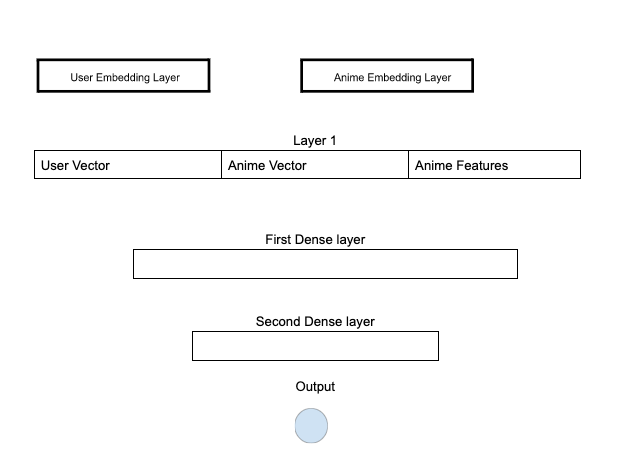

In [23]:
"""
finally the neural network 

"""

class RecommendationNet(nn.Module):
    def __init__(self):
        super(RecommendationNet,self).__init__()
        self.users = nn.Embedding(7551,100) 
        self.animes = nn.Embedding(1275,100)
        self.linear1 = nn.Linear(200+5504,512)
        self.linear2 = nn.Linear(512,128)
        self.linear3 = nn.Linear(128,1)
        
    def forward(self,x):
        user = x[:,1].long() # here am selecting the user and anime ids from the input 
        anime = x[:,2].long() 
        otherfeatures = x[:,2:]
        userVector = self.users(user)
        animeVector = self.animes(anime)
        #print(userVector.shape,animeVector.shape,otherfeatures.shape)#was used for debugging 
        layer1 = torch.cat((userVector,animeVector,otherfeatures),1)# concatenating vectors
        layer2 = F.relu(self.linear1(layer1))
        layer3 = F.relu(self.linear2(layer2))
        out = torch.sigmoid(self.linear3(layer3)) 
        return out

myNN = RecommendationNet()
myNN.to(device)


RecommendationNet(
  (users): Embedding(7551, 100)
  (animes): Embedding(1275, 100)
  (linear1): Linear(in_features=5704, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=1, bias=True)
)

In [27]:
optimizer = optim.Adagrad(myNN.parameters(),lr = 0.0001)

batch_size = 128
test_loss, correct = 0, 0

npData = train.to_numpy()
npData[:,:1] = npData[:,:1]/10 # scaling the target variable
# traintrues = np.expm1(npData[:,4].reshape(-1,1)).reshape(-1)

def ceil(a,b):
    return -(-a//b)

n_samples = len(npData)
better_batch_size = ceil(n_samples, ceil(n_samples, batch_size))

for i in range(10):
    for i in range(ceil(n_samples, better_batch_size)):
        batch = npData[i * better_batch_size: (i+1) * better_batch_size]
        batch = torch.Tensor(batch).to(device)
        X = batch[:,1:]
        y = batch[:,:1]
        myNN.zero_grad()
        pred = myNN(X)
        
        err = F.mse_loss(pred,y)
        
        err.backward()
        optimizer.step()
        
    print("Error",torch.sqrt(err))
   

Error tensor(0.2435, grad_fn=<SqrtBackward0>)
Error tensor(0.1495, grad_fn=<SqrtBackward0>)
Error tensor(0.1111, grad_fn=<SqrtBackward0>)
Error tensor(0.0904, grad_fn=<SqrtBackward0>)
Error tensor(0.0774, grad_fn=<SqrtBackward0>)
Error tensor(0.0686, grad_fn=<SqrtBackward0>)
Error tensor(0.0621, grad_fn=<SqrtBackward0>)
Error tensor(0.0572, grad_fn=<SqrtBackward0>)
Error tensor(0.0533, grad_fn=<SqrtBackward0>)
Error tensor(0.0502, grad_fn=<SqrtBackward0>)


In [28]:
"""
we can use the test df to recommend animes for users
we will choose an arbitrary user id like 183,2812,1156,150 and will choose to show an arbitrary number of animes

"""

npRecommend = test[(test.user_group == 2812)].to_numpy()

npRecommend[:,0] = myNN(torch.Tensor(npRecommend[:,1:]).to(device)).to(device).cpu().detach().numpy().reshape(-1)

indecies =  np.argsort(npRecommend[:,0])[-10:][::-1]

anime_ids = [npRecommend[i,2] for i in indecies]

recommendedAnimes = anime[anime.anime_id.isin(anime_ids)]


In [29]:
recommendedAnimes

,anime_id,name,type,rating,genre,episodes,creators,aired_year,awards_no,descript
508,508,Gakuen Utopia Manabi Straight!,TV Series,7.48,"Comedy, School, Slice of Life",12,13,2007,0,"In 2035, due to the decreasing birth rate in J..."
835,835,Canaan,TV Series,7.29,"Action, Seinen",13,13,2009,0,* Based on a bonus scenario written by Nasu Ki...
916,916,Bakuman.,TV Series,7.98,"Comedy, Romance, Shounen",25,21,2010,2,* Based on a shounen manga by Ooba Tsugumi and...
950,950,Kuragehime,TV Series,7.98,"Comedy, Josei, Slice of Life",11,16,2010,0,* Based on Higashimura Akiko's Kuragehime jose...
956,956,Star Driver: Kagayaki no Takuto,TV Series,6.89,"Action, Mecha, Romance, Shounen",25,16,2010,0,"In Southern Japan, there lies the verdant Mina..."
998,998,Fireball Charming,TV Series,6.82,Sci-Fi,13,3,2011,0,* A series of CGI anime shorts created by Jinn...
1003,1003,Hidan no Aria,TV Series,6.41,"Action, Comedy, Romance, School",12,19,2011,0,* Based on Akamatsu Chuugaku's light novel ser...
1022,1022,No.6,TV Series,6.49,"Action, Sci-Fi",11,14,2011,0,* Based on a science-fiction novel by Asano At...
1107,1107,Sasami-san@Ganbaranai,TV Series,6.21,"Comedy, Romance, Supernatural",12,18,2013,0,"* Based on a light novel series by Akira, with..."
1172,1172,Hentai Ouji to Warawanai Neko.,TV Series,7.00,"Comedy, Harem, Romance, School, Seinen, Supern...",12,15,2013,0,* Based on the light novel by Sagara Sou with ...
